## Building data input pipelines 
>* using the tf.keras.preprocessing.image.ImageDataGenerator class 
## Overfitting issues
> * Image augmentation
> * Dropout
> * Other methods 

In [ ]:
import tensorflow as tf
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [16]:
# data loading
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

# list directories
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/home/ubuntu/.keras/datasets
/home/ubuntu/.keras/datasets/fashion-mnist
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/validation
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/validation/cats
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/train
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/train/dogs
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/train/cats


In [18]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [19]:
# understanding the data
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [20]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [41]:
# model parameters
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE = 150
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [42]:
# Flippping horizontally
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


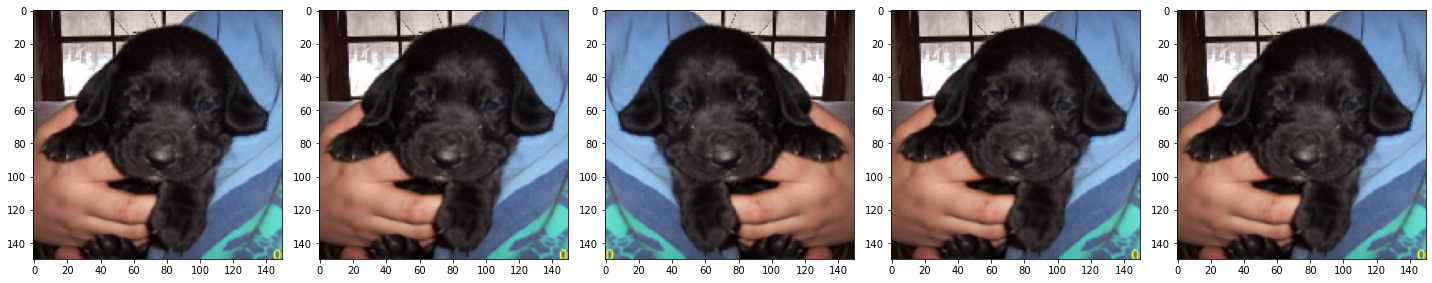

In [43]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [33]:
# Rotating the image
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


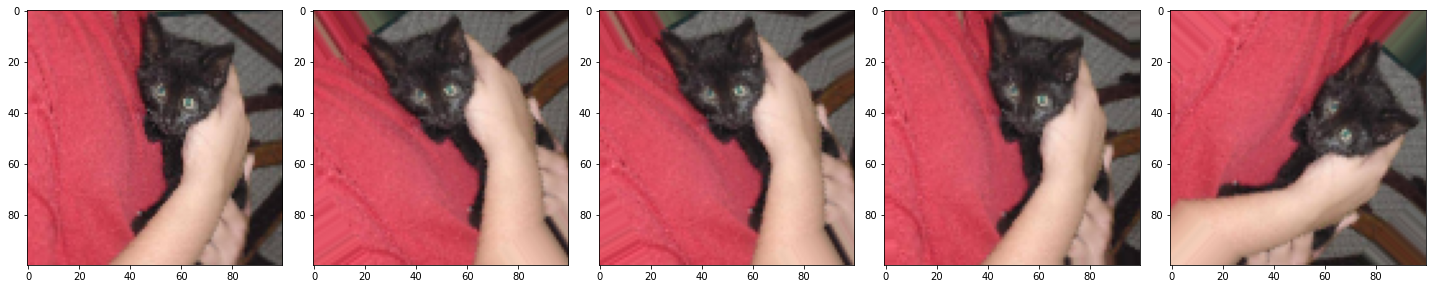

In [34]:
augmented_images = [train_data_gen[0][0][9] for i in range(5)]
plotImages(augmented_images)

In [36]:
# Zoom
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


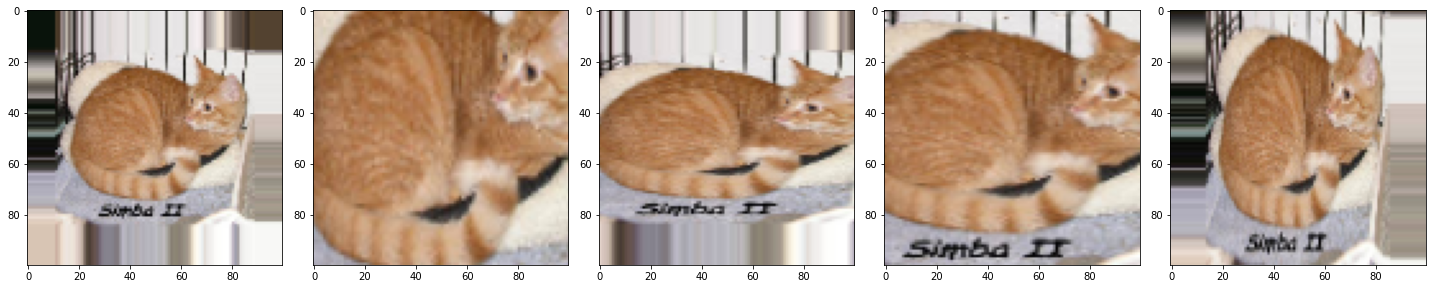

In [37]:
augmented_images = [train_data_gen[0][0][9] for i in range(5)]
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


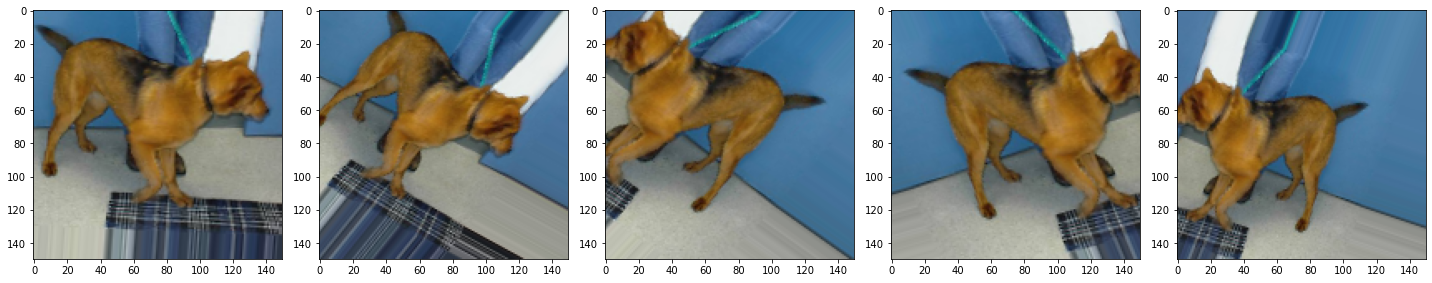

In [44]:
# Putting it all together
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][9] for i in range(5)]
plotImages(augmented_images)

In [45]:
# validation data generation
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=validation_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 1000 images belonging to 2 classes.


In [46]:
DROP_OUT = 0.3

def create_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    #tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    
    tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
    ])
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    
    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_13 (Bat  (None, 148, 148, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_14 (Bat  (None, 72, 72, 64)       256       
 chNormalization)                                                
                                                      

2022-07-31 19:29:36.767726: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_166120"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:7977"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
 

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 7.6925 - accuracy: 0.5455

2022-07-31 19:29:58.769821: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_169956"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:8005"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
 

20/20 [==============================] - 27s 1s/step - loss: 7.6925 - accuracy: 0.5455 - val_loss: 0.8371 - val_accuracy: 0.5390
Epoch 2/100
20/20 [==============================] - 20s 1s/step - loss: 1.4969 - accuracy: 0.5615 - val_loss: 0.9157 - val_accuracy: 0.5500
Epoch 3/100
20/20 [==============================] - 20s 985ms/step - loss: 1.2671 - accuracy: 0.5680 - val_loss: 13.0466 - val_accuracy: 0.5000
Epoch 4/100
20/20 [==============================] - 19s 975ms/step - loss: 0.9605 - accuracy: 0.5760 - val_loss: 14.6890 - val_accuracy: 0.5000
Epoch 5/100
20/20 [==============================] - 20s 997ms/step - loss: 0.9169 - accuracy: 0.5700 - val_loss: 5.8651 - val_accuracy: 0.5000
Epoch 6/100
20/20 [==============================] - 20s 988ms/step - loss: 0.7819 - accuracy: 0.6005 - val_loss: 9.6061 - val_accuracy: 0.5000
Epoch 7/100
20/20 [==============================] - 20s 1s/step - loss: 0.8381 - accuracy: 0.5930 - val_loss: 4.6791 - val_accuracy: 0.5000
Epoch 8/100

In [ ]:
strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():# model creation
    model = create_model()
    epochs=100
    history = model.fit(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    )


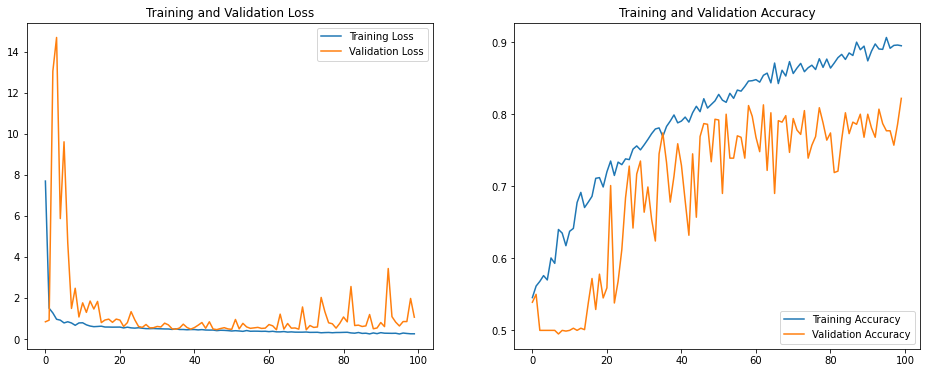

In [47]:
EPOCHS=100

def plot_train(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('./foo.png')
    plt.show()
    
plot_train(history)